In [24]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
torch.manual_seed(824)
np.random.seed(824)
np.set_printoptions(threshold=np.inf)

# build train set
mul1, sigma1 = [1, 0], [[1, 0.75], [0.75, 1]]
mul2, sigma2 = [0, 1], [[1, 0.75], [0.75, 1]]
train_size = 500
test_size = 250

train1 = np.random.multivariate_normal(mean=mul1, cov=sigma1, size=train_size)
train1_label = np.zeros((train_size, 1))

train2 = np.random.multivariate_normal(mean=mul2, cov=sigma2, size=train_size)
train2_label = np.ones((train_size, 1))
X_train = np.vstack([train1, train2])
y_train = np.vstack([train1_label, train2_label])
print("Train set samples: \n",X_train[:5], X_train[-5:])
print("Train set labels: \n", y_train[:5], y_train[-5:])

test1 = np.random.multivariate_normal(mean=mul1, cov=sigma1, size=test_size)
test1_label = np.zeros((test_size, 1))
test2 = np.random.multivariate_normal(mean=mul2, cov=sigma2, size=test_size)
test2_label = np.ones((test_size, 1))
X_test = np.vstack([test1, test2])
y_test = np.vstack([test1_label, test2_label])
print("Test set samples: \n", X_test[:5], X_test[-5:])
print("Test set labels: \n", y_test[:5], y_test[-5:])

Train set samples: 
 [[ 2.58404558  1.29692349]
 [ 1.17246022  1.19740188]
 [ 1.38016946 -0.43532193]
 [ 1.22871198  0.69240206]
 [-0.5638184  -0.03940703]] [[ 0.56631183  2.10367925]
 [-1.20375122 -0.1932487 ]
 [ 0.40916517  2.05219985]
 [-0.04775581  2.34133983]
 [ 0.4270832   0.57494098]]
Train set labels: 
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]] [[1.]
 [1.]
 [1.]
 [1.]
 [1.]]
Test set samples: 
 [[-0.01892415 -0.00839902]
 [ 2.26451904  1.09639391]
 [ 1.01819778  0.83869822]
 [ 2.85415183  0.99880958]
 [ 1.20108847  0.25357878]] [[ 1.69245774  2.16627834]
 [ 0.67392591  1.37774288]
 [-0.70985022  0.94157795]
 [ 1.36430594  2.20540076]
 [ 0.63321523  1.26577979]]
Test set labels: 
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]] [[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [25]:
num_epochs = 100000
learning_rates = [1, 0.1, 0.01, 0.001]

In [26]:
class LogisticReg(torch.nn.Module):
    def __init__(self):
        super(LogisticReg, self).__init__()
        self.fc = torch.nn.Linear(2, 1)
    
    def forward(self, x):
        x = self.fc(x)
        return F.sigmoid(x)

class NormDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.len = x.shape[0]
        self.device = 'cuda'if torch.cuda.is_available() else 'cpu'
        self.x_data = torch.as_tensor(x, device=self.device, dtype=torch.float)
        self.y_data = torch.as_tensor(y, device=self.device, dtype=torch.float)
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len        

loss_func = torch.nn.BCELoss()

In [39]:
train_set, test_set = NormDataset(X_train, y_train), NormDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=32, shuffle=False)
X_test_tsr, y_test_tsr = Variable(torch.from_numpy(X_test).float(), requires_grad=False), Variable(torch.from_numpy(y_test).float(), requires_grad=False)

writer = SummaryWriter()
for lr in learning_rates:
    model = LogisticReg()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    prev_norm, norms, cnt = torch.tensor(0), torch.tensor(0), 0
    print("Parameters before training:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.data)
    for epoch in tqdm(range(num_epochs)):
        early_stop = False
        for i, data in enumerate(train_loader):
            X_train_tsr, y_train_tsr = data
            y_pred = model(X_train_tsr)
            loss = loss_func(y_pred, y_train_tsr)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        norms = torch.norm(model.fc.weight.grad)+torch.norm(model.fc.bias.grad)
        if prev_norm.data==norms.data and cnt<10:
            cnt += 1
        if cnt==10:
            print('Early stopping at {} epoch when norms={}'.format(epoch, norms.data))
            break
        writer.add_scalar('Loss/lr='+str(lr), loss, epoch)
        writer.add_scalar('GradNorm/lr='+str(lr), norms, epoch)
        prev_norm = norms
    test_pred = model.forward(X_test_tsr).data.numpy()
    test_pred = np.where(test_pred>0.5, 1., 0.)
    acc = accuracy_score(test_pred, y_test_tsr.data.numpy())
    print("\nParameters after training:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.data)
    print('\nWhen lr={}, the accuracy is {}'.format(lr, acc))
    print('------'*10)

Parameters before training:
fc.weight tensor([[-0.1240, -0.1621]])
fc.bias tensor([0.3630])


Early stopping at 51 epoch when norms=0.050502777099609375


Parameters after training:
fc.weight tensor([[-2.9807,  3.6594]])
fc.bias tensor([0.9678])

When lr=1, the accuracy is 0.864
------------------------------------------------------------
Parameters before training:
fc.weight tensor([[-0.1468, -0.1365]])
fc.bias tensor([0.3621])


Early stopping at 344 epoch when norms=0.12221948802471161


Parameters after training:
fc.weight tensor([[-3.3510,  3.3664]])
fc.bias tensor([0.0922])

When lr=0.1, the accuracy is 0.914
------------------------------------------------------------
Parameters before training:
fc.weight tensor([[ 0.3347, -0.4135]])
fc.bias tensor([0.0481])


Early stopping at 2440 epoch when norms=0.13401636481285095


Parameters after training:
fc.weight tensor([[-3.4139,  3.3202]])
fc.bias tensor([-0.0060])

When lr=0.01, the accuracy is 0.912
------------------------------------------------------------
Parameters before training:
fc.weight tensor([[ 0.5520, -0.4715]])
fc.bias tensor([0.5648])


Early stopping at 15771 epoch when norms=0.13538068532943726


Parameters after training:
fc.weight tensor([[-3.4145,  3.3100]])
fc.bias tensor([-0.0156])

When lr=0.001, the accuracy is 0.912
------------------------------------------------------------


In [40]:
train_set, test_set = NormDataset(X_train, y_train), NormDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=1, shuffle=False)
X_test_tsr, y_test_tsr = Variable(torch.from_numpy(X_test).float(), requires_grad=False), Variable(torch.from_numpy(y_test).float(), requires_grad=False)

writer = SummaryWriter()
for lr in learning_rates:
    model = LogisticReg()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    prev_norm, norms, cnt = torch.tensor(0), torch.tensor(0), 0
    print("Parameters before training:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.data)
    for epoch in tqdm(range(num_epochs)):
        early_stop = False
        for i, data in enumerate(train_loader):
            X_train_tsr, y_train_tsr = data
            y_pred = model(X_train_tsr)
            loss = loss_func(y_pred, y_train_tsr)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        norms = torch.norm(model.fc.weight.grad)+torch.norm(model.fc.bias.grad)
        if prev_norm.data==norms.data and cnt<10:
            cnt += 1
        if cnt==10:
            print('Early stopping at {} epoch when norms={}'.format(epoch, norms.data))
            break
        writer.add_scalar('Loss/lr='+str(lr), loss, epoch)
        writer.add_scalar('GradNorm/lr='+str(lr), norms, epoch)
        prev_norm = norms
    test_pred = model.forward(X_test_tsr).data.numpy()
    test_pred = np.where(test_pred>0.5, 1., 0.)
    acc = accuracy_score(test_pred, y_test_tsr.data.numpy())
    print("\nParameters after training:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.data)
    print('\nWhen lr={}, the accuracy is {}'.format(lr, acc))
    print('------'*10)

Parameters before training:
fc.weight tensor([[-0.7055,  0.0255]])
fc.bias tensor([-0.2273])


Early stopping at 15 epoch when norms=0.003028314560651779


Parameters after training:
fc.weight tensor([[-2.8413,  3.3302]])
fc.bias tensor([5.6395])

When lr=1, the accuracy is 0.552
------------------------------------------------------------
Parameters before training:
fc.weight tensor([[-0.0246, -0.4560]])
fc.bias tensor([-0.1986])


Early stopping at 27 epoch when norms=0.0748012363910675


Parameters after training:
fc.weight tensor([[-2.6917,  3.3682]])
fc.bias tensor([2.3081])

When lr=0.1, the accuracy is 0.77
------------------------------------------------------------
Parameters before training:
fc.weight tensor([[ 0.2296, -0.2112]])
fc.bias tensor([-0.6161])


Early stopping at 103 epoch when norms=0.49514836072921753


Parameters after training:
fc.weight tensor([[-3.1573,  3.4086]])
fc.bias tensor([0.2957])

When lr=0.01, the accuracy is 0.922
------------------------------------------------------------
Parameters before training:
fc.weight tensor([[0.4855, 0.6238]])
fc.bias tensor([0.4780])


Early stopping at 726 epoch when norms=0.6689199209213257


Parameters after training:
fc.weight tensor([[-3.3658,  3.3036]])
fc.bias tensor([-0.0130])

When lr=0.001, the accuracy is 0.91
------------------------------------------------------------


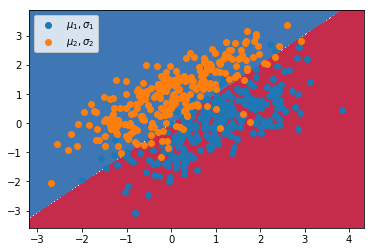

In [68]:
import matplotlib.pyplot as plt
# Visualizations

def plot_decision_boundary(X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    test_grid = np.c_[xx.ravel(), yy.ravel()]
    test_grid_tsr = torch.from_numpy(test_grid).type(torch.FloatTensor)
    Z = model(test_grid_tsr)
    Z = np.where(Z>0.5, 1., 0.)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(test1[:, 0], test1[:, 1], label='$\mu_1, \sigma_1$')
    plt.scatter(test2[:, 0], test2[:, 1], label='$\mu_2, \sigma_2$')
    plt.legend()

plot_decision_boundary(X_test, y_test)